<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/AprendizajeAutomatico/TP2/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ciencias de los Datos:
# Aprendizaje automático

## Trabajo práctico 2

- Professor: M.Sc.Saul Calderon.

- Students: 
    - Felipe Alberto Mejías Loría, Instituto Tecnológico de Costa Rica. 
    - María Auxiliadora Mora, Instituto Tecnológico de Costa Rica  

- July 28th, 2019   

In [0]:
# Libraries required for the exercises
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split as tts

## 1. Implementación de clasificadores lineales de dos clases. (40 puntos)

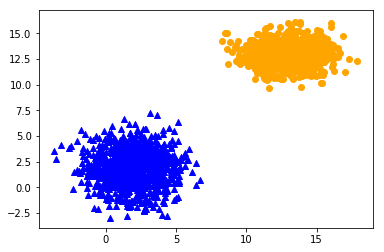

>epoch=0, cost=9560.333
>epoch=1, cost=9518.887
>epoch=2, cost=9505.071
>epoch=3, cost=9435.993
>epoch=4, cost=9325.470
>epoch=5, cost=9049.159
>epoch=6, cost=8303.121
>epoch=7, cost=151.969
>epoch=8, cost=13.814
>epoch=9, cost=13.814
>epoch=10, cost=13.814
>epoch=11, cost=-0.001
>epoch=12, cost=-0.001
>epoch=13, cost=-0.001
>epoch=14, cost=-0.001
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.001
>epoch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


In [85]:
def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [6, 6], stds1 = [3, 3], stds2 = [2, 1]):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2
    """
    means = torch.zeros(2)

    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]

    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
        
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)

    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1], marker='^', c='blue')
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker='o', c='orange')

    plt.show()
    
    # Create samples with bias
    samplesAllBias = torch.cat((samplesClass1Bias, samplesClass2Bias), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = 0 * torch.ones(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAllBias)


def createDataOneClass(means, covarianceMatrix, numberSamples):
    """
    Creates data with gaussian distribution
    """
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    return samples

def sigmoid(x):
    """
    Sigmoid activation function
    """
    return 1/(1+np.exp(-x))

def forward(samples, w, threshold=0.5, lowerLimit = 0, upperLimit = 1):
    """
    Get model output.
    param samples: samples used to estimated targets. 
    param w: network's weights. 
    param threshold: neuron's threshold of the transfer function.
    param lowerLimit: lower limit of the transfer function.
    param upperLimit: upper limit of the transfer function.
    return: Estimates the model outputs using the sigmoid activation function with values of lowerLimit and upperLimit.   
    """

    # Define vectorize sigmoid to apply to m*w
    vectorize_sigmoid = np.vectorize(sigmoid)
    EstimatedTargets = samples.mm(w)
    
    # Apply sigmoid function to m*w
    EstimatedTargets = torch.from_numpy(vectorize_sigmoid(EstimatedTargets.numpy())).type(torch.FloatTensor)
    
    # Classify predictions
    EstimatedTargets[EstimatedTargets>threshold] = upperLimit
    EstimatedTargets[EstimatedTargets<=threshold] = lowerLimit
    
    return EstimatedTargets

def vectorTransposed(w):
    """
    Calculate the transposed of a vector.
    return: the transposed vector.   
    """
    w2Drow = w.reshape(-1, w.shape[0])
    return w2Drow.transpose(0, 1)  

def calculateError(targets, estimated_targets):
    """
    Calculate the cost using the versimilitude error. 
    """
    cost = ((targets*torch.log((estimated_targets+0.1e-5))) + (1-targets)*torch.log((1-estimated_targets + 0.1e-5)))
    return -torch.sum(cost)

def train_model(samples, targets, epochs=10):
   """
   Train the logistic regression model adjusting the neural network's weights.
   param samples: Conjunction of entries
   param targets: Types of clases (Class 1 and Class 2)
   param epochs: number of training cycles.
   return: updated weights   
   """

   def updateDeltaWeight(samples, targets_transpose, estimated_targets_transpose, wT, alpha=0.1):
      """
      Estimate delta weight using stochastic gradient descent
      param SamplesAllBias: NumSamples x NumDimensions 
      param TargetsAllT: NumSamples' clases 
      param EstimatedTargetsAllT: estimated clases
      param wT: previous weights
      param eta: learning rate
      
      return: updated weights.   
      """
      samples_transpose = samples.transpose(0, 1)    
      return wT + alpha * samples_transpose.mm(targets_transpose - estimated_targets_transpose)
   

   # Generate random weights
   samples_dimensions = samples.size()
   w = torch.ones(samples_dimensions[1],1)
   wT = vectorTransposed(w)

   # Calculate Targets transpose 
   targets_transpose = vectorTransposed(targets)

   # Train during n epochs
   for epoch in range(epochs):
       # Calculate predictions (estimated targets)
       estimated_targets_transpose = vectorTransposed(forward(samples, wT))
       
       # Calculate error
       error  = calculateError(targets_transpose, estimated_targets_transpose)
       print('>epoch=%d, cost=%.3f' % (epoch, error))
        
       if error > 0.1e-5 :  
          # Update weights 
          wT = updateDeltaWeight(samples, targets_transpose, estimated_targets_transpose, wT)

       epoch = epoch + 1

   return wT


# Test the logistic regression model  
def logistic_regression(samples, targets, epochs = 50, test_size = 0.3):    

    # Define the set of training samples as 70% (randomly selected) and test samples as 30%.
    X_train, X_test, Y_train, Y_test = tts(samples.numpy(), targets.numpy(), test_size = test_size)

    # Train the logistic regression model
    wF = train_model(torch.tensor(X_train), torch.tensor(Y_train), epochs=epochs)

    # Test the trained logistic regression model
    Estimated_Y = forward(torch.tensor(X_test), wF)

    # Calculate error
    testError = calculateError(torch.tensor(Y_test), Estimated_Y )
    print("Error total para el conjunto de muestras:", testError)
    return testError


def test_logistic_regression():
    (targets, samples) = createData(numberSamplesPerClass = 1000, mean2 = [13, 13])
    finalError = logistic_regression(samples, targets, epochs = 50, test_size = 0.3)
    

test_logistic_regression()

#¿Cuál de las funciones matemáticas vistas en clase puede utilizarse a la salida del regresor logístico para realizar una clasificación binaria?
Se puede utilizar la función sigmoidal ya es una función suave y continua acotada entre 0 y 1.




## 2. Experimentos, análisis y el enfoque de mínimos cuadrados regularizado. (60 puntos)

Original image


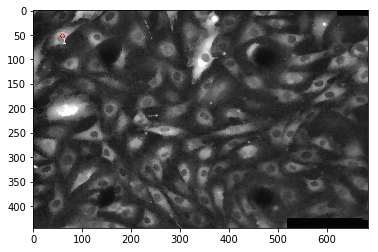



Image Histogram with 255 Bins


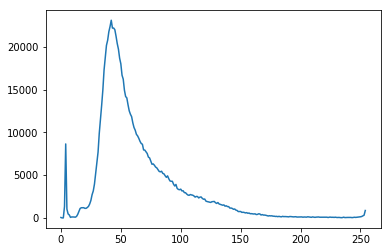



Image Normalized Histogram with 255 Bins


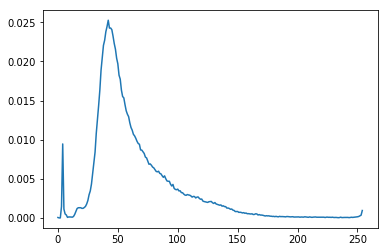

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in log


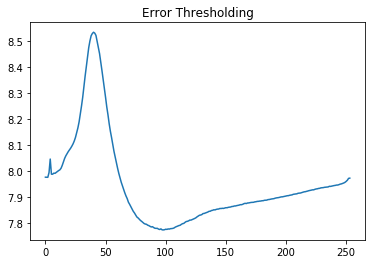

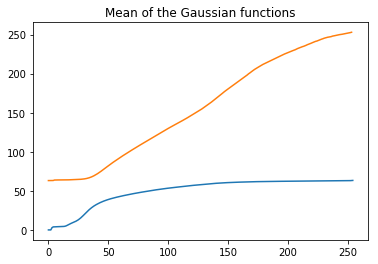

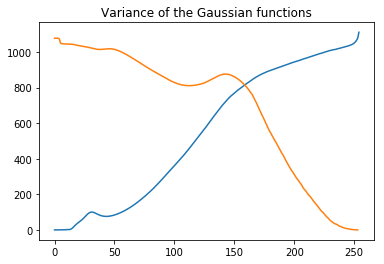


Obtained results:
Optimum threshold obtained:               98
Media in T of the Gaussian function 1:    tensor(53.0399)
Media in T of the Gaussian function 2:    tensor(128.2649)
Variance in T of the Gaussian function 1: tensor(345.5976)
Variance in T of the Gaussian function 2: tensor(834.3124)


Thresholded image


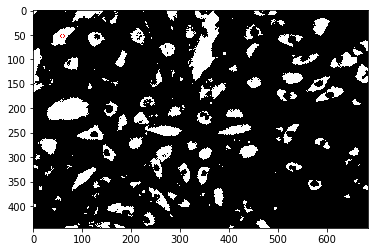

In [0]:
#Exercise 2
def exercise2(imgPath='https://www.dropbox.com/sh/wik46x4bhv5hhgv/AAB-XniFCk1jTttL5MQ_MulTa/TrabajosPracticos/TP1/input/trackedCell15.tif?dl=1'):
  # Plot Original Image
  image = plotOriginalImage(imgPath)
  
  # Apply Kittler Algorithm
  threshold = exercise_1_a(image)
  
  # Plot Threshold Image
  plotThresholdedImage(imgPath, threshold)

# Test exercise 2
exercise2()
